In [120]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Automatic differentiation of RNA circuit dynamics

# Imports

In [121]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import optax
import equinox
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import diffrax as dfx
from typing import List

from functools import partial
import os
import sys

from bioreaction.simulation.simfuncs.basic_de import one_step_de_sim_expanded

jax.config.update('jax_platform_name', 'gpu')

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


# os.environ['EQX_ON_ERROR']='breakpoint'
# os.environ['JAX_DISABLE_JIT']='1'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

np.random.seed(0)
jax.devices()

[cuda(id=0), cuda(id=1)]

In [122]:
from synbio_morpher.srv.parameter_prediction.simulator import make_piecewise_stepcontrol
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.modelling.physical import eqconstant_to_rates, equilibrium_constant_reparameterisation
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.modelling.solvers import get_diffrax_solver, make_stepsize_controller, simulate_steady_states
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation, compute_peaks, compute_adaptability_full
from bioreaction.simulation.simfuncs.basic_de import bioreaction_sim, bioreaction_sim_expanded, one_step_de_sim_expanded


# Set up test environment

In [123]:
def make_species_bound(species_unbound):
    return sorted(set(flatten_listlike([['-'.join(sorted([x, y])) for x in species_unbound] for y in species_unbound])))


# RNA circuit settings
species_unbound = ['RNA_0', 'RNA_1', 'RNA_2']
species_bound = make_species_bound(species_unbound)
species = species_unbound + species_bound
species_signal = ['RNA_0']
species_output = ['RNA_2']
# species_output = ['RNA_1', 'RNA_2']
species_nonsignal = [s for s in species_unbound if s not in species_signal]
idxs_signal = np.array([species.index(s) for s in species_signal])
idxs_output = np.array([species.index(s) for s in species_output])
idxs_unbound = np.array([species.index(s) for s in species_unbound])
idxs_bound = np.array([species.index(s) for s in species_bound])
signal_onehot = jnp.array([1 if s in idxs_signal else 0 for s in np.arange(len(species))])
signal_onehot_inv = (signal_onehot == 0) * 1.0

# Circuit parameters
n_circuits = 10
n_circuits_display = 10
key = random.PRNGKey(0)
N0 = 200
y00 = np.array([[N0] * len(species_unbound) + [0] * len(species_bound)]).astype(np.float32)
y00 = np.repeat(y00, repeats=n_circuits, axis=0)

# Dynamic Simulation parameters
k_a = 0.00150958097
signal_target = 2
t0 = 0
t1 = 10
ts = np.linspace(t0, t1, 500)
tmax = 1000
dt0 = 0.005555558569638981
dt1_factor = 5
dt1 = dt0 * dt1_factor
max_steps = 16**4 * 10
use_sensitivity_func1 = False
sim_method = 'Dopri8'
stepsize_controller = 'adaptive'
threshold_steady_state = 0.01
batch_size = 10
n_steps = 1                   # Number of optimization steps

# Reactions
energies = random.normal(key, (n_circuits, len(np.tril_indices(len(species_unbound))[0])))
energies = np.interp(energies, (energies.min(), energies.max()), (-25, 0))
eqconstants = jax.vmap(partial(equilibrium_constant_reparameterisation, initial=N0))(energies)
forward_rates, reverse_rates = eqconstant_to_rates(eqconstants, k_a)
forward_rates = forward_rates[0]

inputs = np.array([
    [2, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
], dtype=np.float64)
outputs = np.array([
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
], dtype=np.float64)

# ODE functions

In [124]:
sim_func = partial(bioreaction_sim_dfx_expanded,
                   t0=t0, t1=t1, dt0=dt0,
                   forward_rates=forward_rates,
                   inputs=inputs,
                   outputs=outputs,
                   solver=get_diffrax_solver(sim_method),
                   stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1, choice=stepsize_controller))

In [ ]:
def obj_s(ts, t1, dy, y, y0, w_deriv=500):
    # return - jnp.divide(jnp.power(y - y0, 2), y0)
    # return w_deriv * (jnp.power(dy, 2) / jnp.power(dy, 2).sum()) * jnp.power(jnp.divide(y - y0, y0), 2)
    # deriv_term = jnp.divide(jnp.power(dy, 2), jnp.sqrt(jnp.power(dy, 2).sum()))
    time_term = 1-jnp.exp(-ts)
    deriv_term = jnp.power(dy * time_term, 2)
    return jnp.power(jnp.divide(y - y0, y0), 2) * deriv_term
    # return jnp.exp(jnp.power(jnp.divide(y - y0, y0), 2) * deriv_term)


def obj_p(dy, y, y0):
    # return jnp.divide(jnp.power(y - y0, 2), y0)
    # return jnp.power(jnp.divide(y - y0, y0), 2)
    deriv_term = jnp.power(dy, 2)
    return jnp.exp(-(jnp.power(jnp.divide(y - y0, y0), 2) + deriv_term))


def objective_sp(s, p, ttot, idxs_output, s_weight=1, return_aux=False):
    s_objective = s_weight * (s[..., idxs_output].sum() / ttot)
    p_objective = p[..., idxs_output].sum() / ttot
    if return_aux:
        return s_objective * p_objective, (s_objective, p_objective)
    return s_objective * p_objective


def simulate_signal(y0, reverse_rates, t0, t1):
    sol = partial(sim_func, return_as_sol=True, 
                  saveat=dfx.SaveAt(ts=jnp.linspace(t0, t1, 500), dense=True))(
        y0=y0, reverse_rates=reverse_rates)
    ddy_dt = jax.vmap(sol.derivative)(sol.ts)
    y_sens = obj_s(sol.ts[..., -1], t1-t0, ddy_dt, sol.ys, y0)
    y_prec = obj_p(ddy_dt, sol.ys, y0)
    return sol.ts, (sol.ys, ddy_dt, y_sens, y_prec)


def simulate(y0, params):
    """ (y11, ddys1, y_sens, y_prec) = ys1 """
    ts0, ys0 = partial(sim_func, saveat=dfx.SaveAt(ts=jnp.linspace(t0, t1, 500)))(y0=y0, reverse_rates=params)
    y01 = (jnp.array(ys0[..., -1, :].shape) * signal_onehot * signal_target) + (jnp.array(ys0[..., -1, :].shape) * signal_onehot_inv)
    # y01[:, idxs_signal] = signal_target * y01[:, idxs_signal]
    ts1, ys1 = simulate_signal(y0=y01, reverse_rates=params, t0=t0, t1=t1)
    # (y11, ddys1, y_sens, y_prec) = ys1
    return (ts0, ys0), (ts1, ys1)

In [126]:
# y0 = y00[:10]
# params = reverse_rates[:10]

# (ts0, ys0), (ts1, ys1) = simulate(y0, params=params)

## Visualise ODE sim

In [127]:
visualise = False

if visualise:
    y0 = y00[:10]
    params = reverse_rates[:10]

    (ts0, ys0), (ts1, ys1) = simulate(y0, params)
    (y11, ddys1, y_sens, y_prec) = ys1

    n_plots=6
    plt.figure(figsize=(5*n_plots, 5))
    titles = ['y', 'ddy', 'y_sens', 'y_prec']
    i_circ = 5
    for i, title in enumerate(titles):
        ax = plt.subplot(1, n_plots, i+1)
        plt.plot(ts, ys1[i][i_circ, :, idxs_output].T)
        plt.title(title)
        plt.legend(species_output)
    ax = plt.subplot(1, n_plots, 5)
    plt.plot(ts, (ys1[2][i_circ, :, idxs_output].T * ys1[3][i_circ, :, idxs_output].T))
    plt.title('y_sens * y_prec')
    plt.legend(species_output)

    ax = plt.subplot(1, n_plots, 6)
    plt.plot(ts, ((ys1[1] ** 2)[i_circ, :, idxs_output].T * ys1[3][i_circ, :, idxs_output].T))
    plt.legend(species_output)
    plt.title('ddy^2 * y_prec')

    print(y_sens.sum()/ t1, y_prec.sum()/t1)

In [128]:
if visualise:
    ts = jnp.concatenate([ts0, ts1 + ts0.max()], axis=1)[0]
    ys = jnp.concatenate([ys0, ys1[0]], axis=1)
    loss = jax.vmap(partial(objective_sp,
                            ttot=t1-t0, idxs_output=idxs_output))(y_sens, y_prec)

    nr = int(np.ceil(np.sqrt(len(params))))
    nc = int(np.ceil(np.sqrt(len(params))))

    plt.figure(figsize=(5*nc, 5*nr))
    for i in range(len(params)):
        plt.subplot(nr, nc, i+1)
        plt.plot(ts1[0], y11[i][..., idxs_output])
        
        plt.title(f'Circuit {i}: loss = {loss[i]}')

In [129]:
# # Define the ODE function
# def ode_func(t, y, params):
#     return params.sum(axis=-1) - y  # (y * params).sum(axis=-1) - y


# def smooth_max(a, b, epsilon=1e-2):
#     """ Smooth approximation for maximum """
#     return epsilon * jnp.log(jnp.exp(a / epsilon) + jnp.exp(b / epsilon))


# def smooth_max2(a, b):
#     """ Smooth maximum approximation using softplus"""
#     return jnp.log1p(jnp.exp(a - b)) + b  # Softplus-based approximation


# def max_value_ode(t, y, args):
#     """ `args` is a tuple (params, max_val) """
#     params, epsilon = args
#     max_val = y[1]
#     dy_dt = ode_func(t, y[0], params)
#     # max_val = jnp.max(jnp.vstack([max_val, y[0]]), axis=0)
#     max_val = smooth_max(max_val, y[0], epsilon)
#     # return dy_dt, jnp.sin(y[0])
#     return dy_dt, max_val


# def ode_sp(t, y, args):
#     params, y0 = args
#     # y_t, y_sens, y_prec = y
#     y_t = y
#     dy_dt = sim_func(t, y_t, args, reverse_rates=params)
#     y_sens = obj_s(dy_dt, y_t, y0)
#     y_prec = obj_p(y_t, y0)
#     return dy_dt #, y_sens, y_prec


# # Modified function to solve the ODE and track the maximum value with params
# def solve_ode_and_track_max(y0, params, t0, t1, dt0, dt1, stepsize_controller, max_steps=1000, idx_output=-1):

#     # Solve the ODE with an auxiliary variable to track the max
#     solution = dfx.diffeqsolve(
#         dfx.ODETerm(ode_sp),
#         solver=get_diffrax_solver(sim_method),
#         t0=t0,
#         t1=t1,
#         dt0=dt0,
#         y0=y0,
#         # y0=(y0, y0, y0),
#         args=(params, y0),  # Pass params and initial max as args
#         saveat=dfx.SaveAt(ts=jnp.linspace(t0, t1, max_steps)),
#         stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1,
#                                                      choice=stepsize_controller)
#         # adjoint=dfx.BacksolveAdjoint()  # This enables differentiation
#     )

#     y_sens, y_prec = solution.ys[1][-2:]  # Get the max value reached
#     return solution, y_sens[idx_output], y_prec[idx_output]


# def solve_naive(y0, params, t0, t1, dt0, max_steps=10000, idx_output=-1):

#     y, y_sens, y_prec = y0, y0, y0
#     # , np.zeros((max_steps, len(y0))), np.zeros((max_steps, len(y0)))
#     ys, ys_sens, ys_prec = np.zeros((3, max_steps, len(y0)))
#     for i_t, tstep in enumerate(np.linspace(t0, t1, max_steps)):
#         dy_dt, y_sens, y_prec = ode_sp(
#             tstep, (y, y_sens, y_prec), (params, y0))
#         y = y + dy_dt * dt0
#         ys[i_t] = y
#         ys_sens[i_t] = y_sens
#         ys_prec[i_t] = y_prec
#     return ys, ys_sens, ys_prec

# Optimisation functions

In [130]:
def param_transform(params, param_type):
    """ Transform the input parameters into the reverse rates
    depending on their type """
    
    fn_trans = (jax.vmap(partial(equilibrium_constant_reparameterisation, initial=N0)),
                lambda x: eqconstant_to_rates(x, k_a)[1])
    
    if param_type == 'reverse_rates':
        return params
    elif param_type == 'eqconstants':
        return fn_trans[0](params)
    elif param_type == 'energies':
        for f in fn_trans:
            params = f(params)
        return params
    else:
        raise ValueError(f'unknown parameter type {param_type}')


# @jax.jit
def loss_fn(params, y0, t0, t1, param_type):
    """ Define a loss function to optimize params """
    params_trans = param_transform(params, param_type)
    (ts0, ys0), (ts1, ys1) = simulate(y0, params_trans)
    (y11, ddys1, y_sens, y_prec) = ys1

    loss, (s_obj, p_obj) = partial(objective_sp, ttot=t1-t0, idxs_output=idxs_output, return_aux=True)(y_sens, y_prec)
    
    return loss, (s_obj, p_obj, y11, ddys1, y_sens, y_prec)

# @jax.jit
def batch_loop(params_b, y0b, t0, t1, param_type):
    (loss_b, aux), grads_b = jax.vmap(jax.value_and_grad(
        partial(loss_fn, t0=t0, t1=t1, param_type=param_type), has_aux=True))(params_b, y0b)
    return loss_b, grads_b, params_b, aux


def update_params(updates, params, param_type):
    params = optax.apply_updates(params, updates)
    if param_type == 'energies':
        params = jnp.where(params < -25, -25, params)        
        params = jnp.where(params > 0, 0, params)        
    return params


# @jax.jit
@equinox.filter_jit
def optimise_step(params, opt_state, y0, t0, t1, optimiser, batch_size, param_type):
    def extend_batch(xs, xsb):
        if xs is None:
            xs = xsb
        else:
            xs = jnp.concatenate([xs, xsb])
        return xs

    loss, grads, aux = (None, None, {})
    for batch_step in range(0, len(params), batch_size):
        print(f"Batch step: {batch_step}/{len(params)}")
        i0, i1 = batch_step, batch_step + batch_size
        params_b, y0b = (params[i0:i1], y0[i0:i1])

        loss_b, grads_b, params_b, aux_b = batch_loop(
            params_b, y0b, t0, t1, param_type)

        # params = jax.ops.index_update(params, jax.ops.index[i0:i1], params_b)
        loss = extend_batch(loss, loss_b)
        grads = extend_batch(grads, grads_b)
        for i, aux_bi in enumerate(aux_b):
            aux[i] = extend_batch(aux.get(i), aux_bi)
        
    updates, opt_state = optimiser.update(grads, opt_state)
    params = update_params(updates, params, param_type)
    return params, opt_state, loss, grads, aux

# Run sim

In [131]:
params = energies
param_type = 'energies'

# Set up optax optimiser
optimiser = optax.adam(learning_rate=0.1)
opt_state = optimiser.init(params)

# Optimization loop
loss_all = np.zeros((n_steps, params.shape[0]))
grads_all = np.zeros((n_steps, *params.shape))
params_all = np.zeros((n_steps, *params.shape))
aux_all = {}
for i in range(n_steps):
    print(f'Step {i}')
    params, opt_state, current_loss, current_grads, current_aux = optimise_step(
        params, opt_state, y00, t0, t1, optimiser, batch_size, param_type)
    if i % 2 == 0:
        print(f"Step {i}\n\tLoss: {current_loss[0]}\n\tGrads: {current_grads[0]}\n\tParams: {params[0]}")
    grads_all[i] = current_grads
    loss_all[i] = current_loss
    params_all[i] = params
    aux_all[i] = current_aux

print(f"Optimized Params: {params[:5]}")


Step 0
Batch step: 0/10
Step 0
	Loss: 77268.3125
	Grads: [ 8.0769035e+01  3.9815868e+01 -7.6514507e+03  4.8690934e+00
 -2.3780522e+03  5.6495793e+04]
	Params: [-15.887684  -16.295311  -13.366932   -1.2313426 -14.857295   -4.3535514]
Optimized Params: [[-15.887684  -16.295311  -13.366932   -1.2313426 -14.857295   -4.3535514]
 [-21.549921  -11.506111  -11.720403   -7.8625817  -6.848053  -14.782501 ]
 [-12.630828  -25.         -8.904433   -4.1083193  -1.8758247  -8.986115 ]
 [-11.098906   -3.1317062  -0.8172829  -9.516196   -7.8829746 -17.736242 ]
 [ -7.8181    -12.279025  -13.785633  -13.132776  -13.023521   -6.607896 ]]


In [132]:
# Get all aux variables
aux = {}
for step, aux_step in aux_all.items():
    for i, v in aux_step.items():
        v = np.expand_dims(v, axis=0)
        if aux.get(i) is not None:
            aux[i] = np.vstack([aux[i], v])
        else: aux[i] = v
        
(s_obj_all, p_obj_all, y11_all, ddys1_all, y_sens_all, y_prec_all) = list(aux.values())

# Visualise optimised parameters

In [133]:
# (ts0, ys0), (ts1, ys1) = jax.vmap(simulate)(y00, params_all[-2])
# (y11, ddys1, y_sens, y_prec) = ys1
(s_obj_last, p_obj_last, y11, ddys1, y_sens, y_prec) = (s_obj_all[-1], p_obj_all[-1], y11_all[-1], ddys1_all[-1], y_sens_all[-1], y_prec_all[-1])

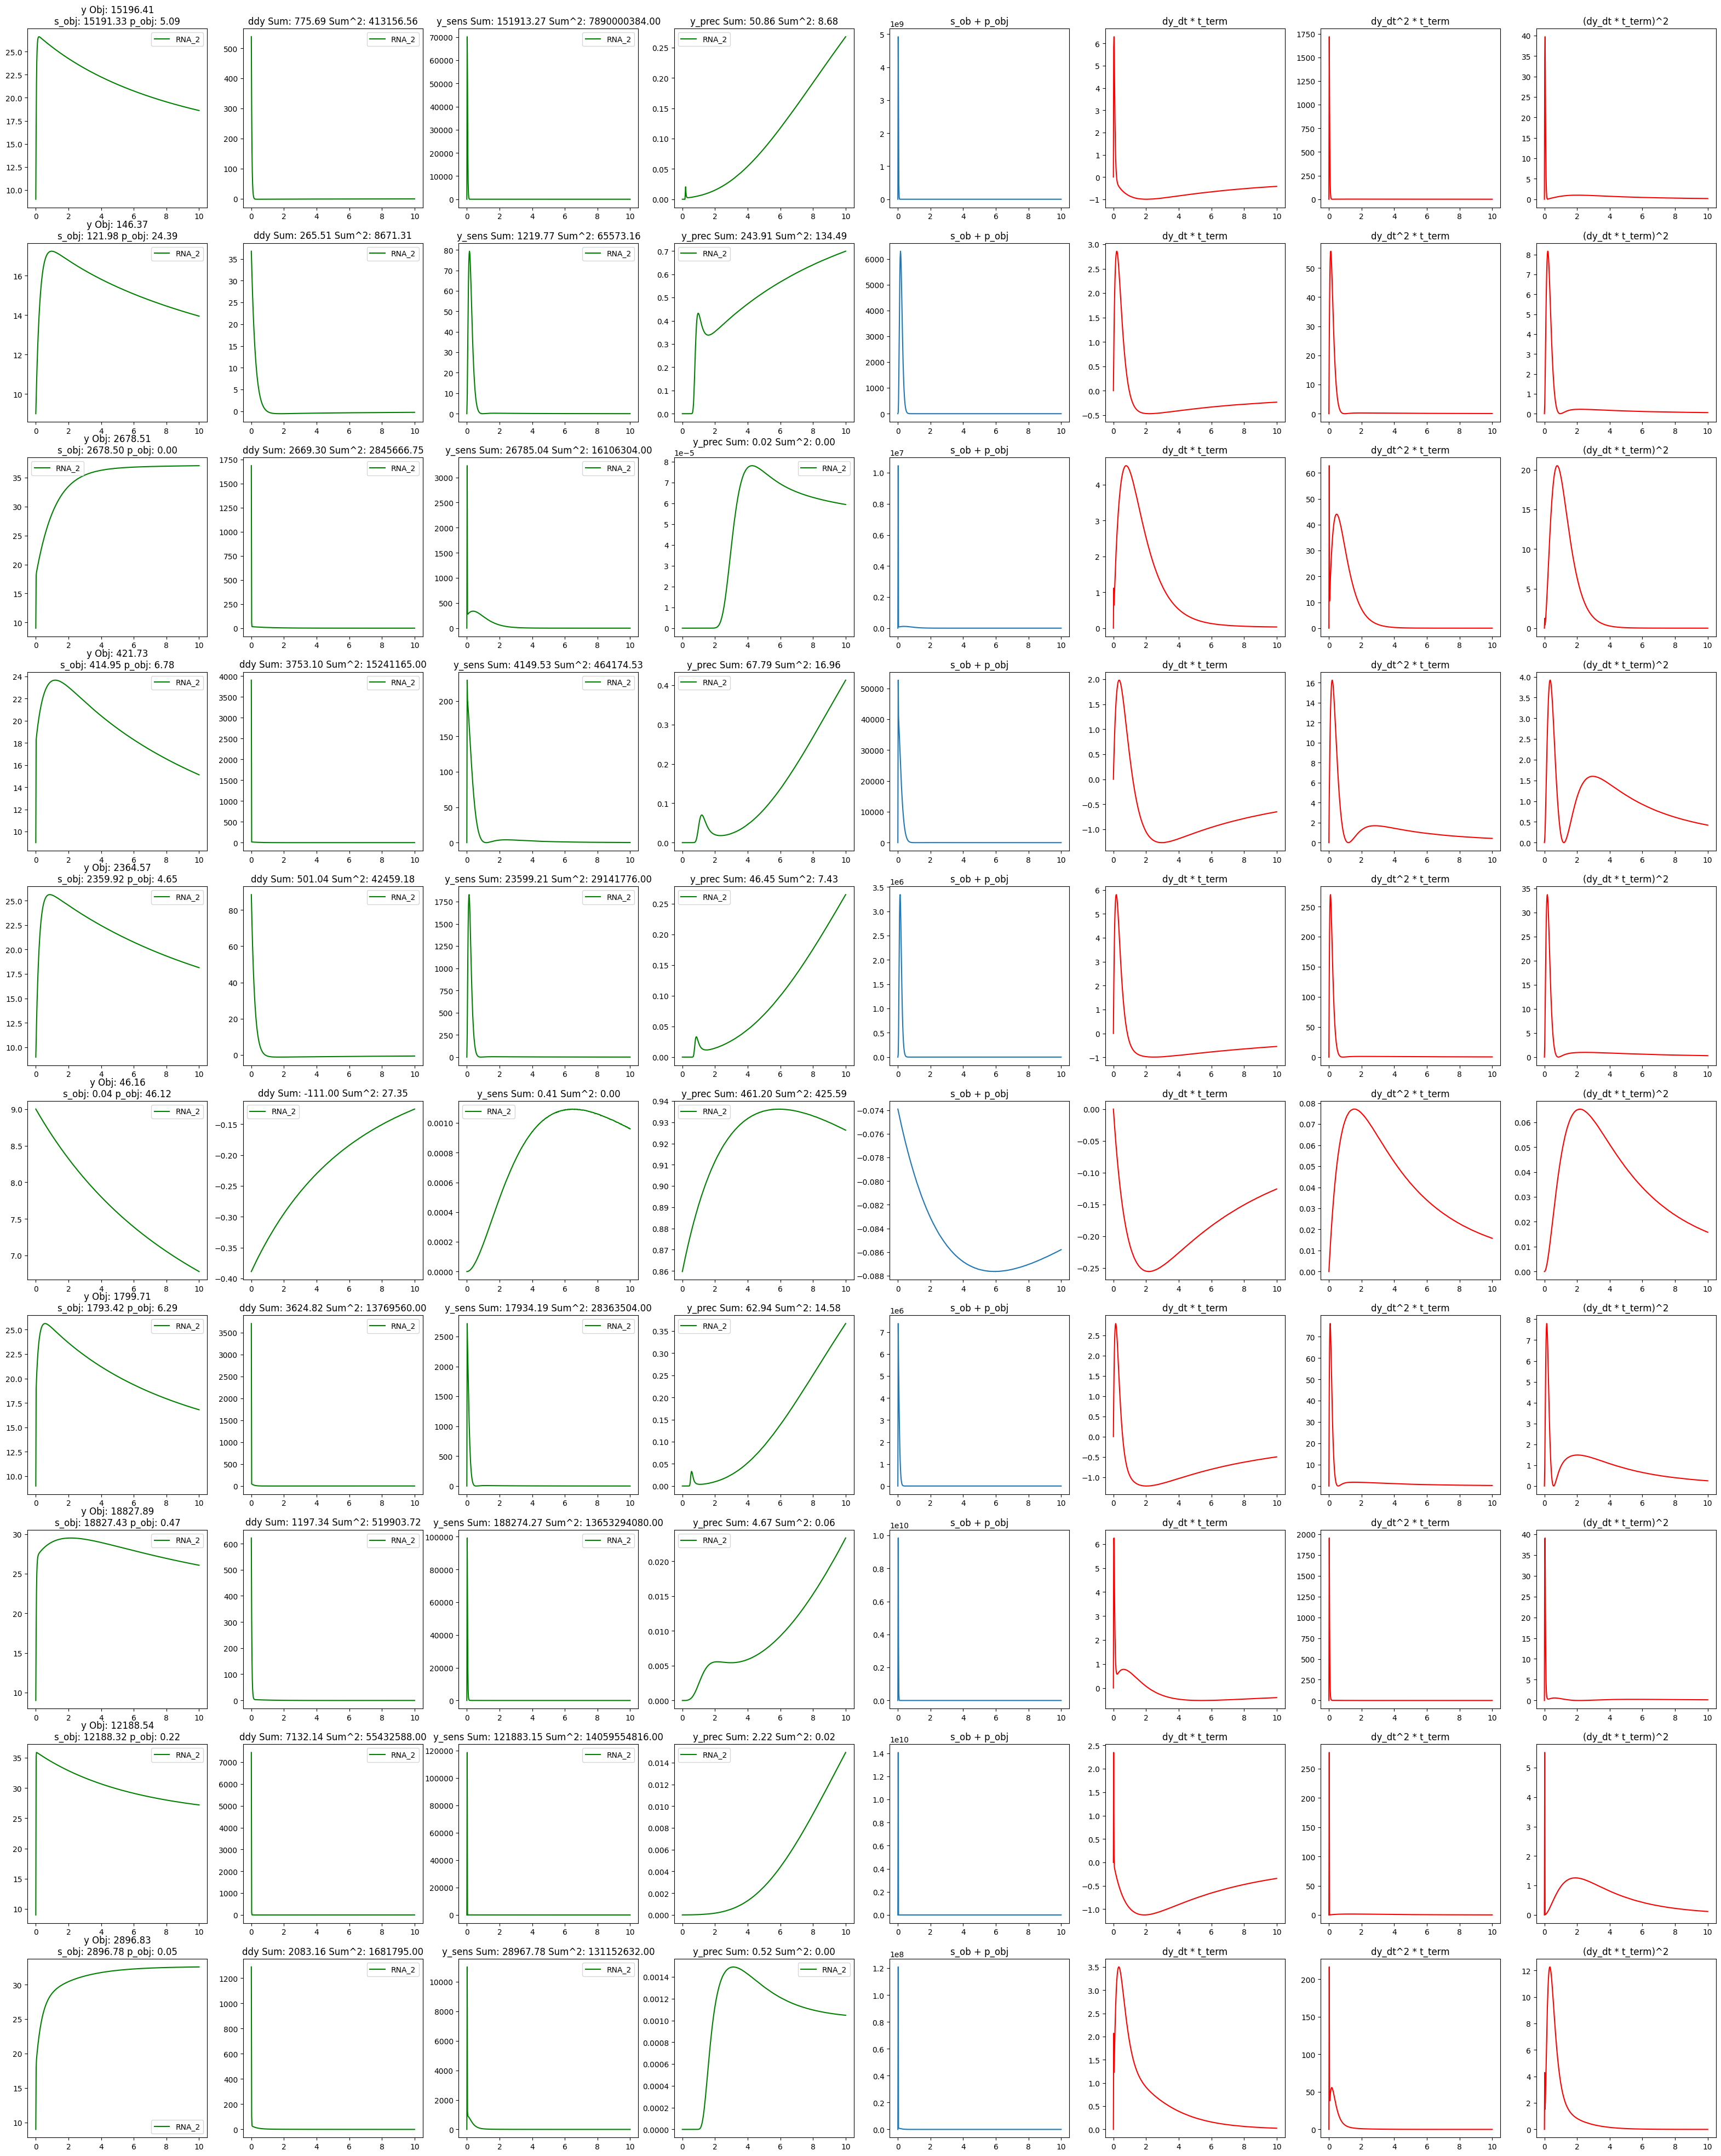

In [140]:
n_plots = 11
auxs_final = (y11, ddys1, y_sens, y_prec)
nc = n_plots
nr = n_circuits_display
plt.figure(figsize=(5*n_plots, 5*n_circuits_display))
titles = ['y', 'ddy', 'y_sens', 'y_prec']
for i_circ in range(n_circuits_display):
    for i, title in enumerate(titles):
        ax = plt.subplot(nr, nc, i_circ*nc + (i+1))
        plt.plot(ts, auxs_final[i][i_circ, :, idxs_output].T, color='g')
        plt.title(title + (f' Obj: {s_obj_last[i_circ] + p_obj_last[i_circ]:.2f}\ns_obj: {s_obj_last[i_circ]:.2f} p_obj: {p_obj_last[i_circ]:.2f}' if i ==
                  0 else f' Sum: {auxs_final[i][i_circ, :, idxs_output].sum():.2f} Sum^2: {np.power(auxs_final[i][i_circ, :, idxs_output], 2).sum():.2f}'))
        plt.legend(species_output)
    # ax = plt.subplot(nr, nc, i_circ*nc + 5)
    # res = (auxs_final[2][i_circ, :, idxs_output].T *
    #         auxs_final[3][i_circ, :, idxs_output].T)
    # plt.plot(ts, res)
    # plt.title(f'y_sens * y_prec Sum: {res.sum():.2f}')
    # plt.legend(species_output)

    # ax = plt.subplot(nr, nc, i_circ*nc + 6)
    # res = ((auxs_final[1] ** 2)[i_circ, :, idxs_output].T *
    #         auxs_final[3][i_circ, :, idxs_output].T)
    # plt.plot(ts, res)
    # plt.legend(species_output)
    # plt.title(f'ddy^2 * y_prec Sum: {res.sum():.2f}')

    ax = plt.subplot(nr, nc, i_circ*nc + 5)
    s_obj_i = 10 * ((auxs_final[2] ** 2)[i_circ, :, idxs_output] / (t1-t0))
    p_obj_i = - ((auxs_final[3] ** 2)[i_circ, :, idxs_output] / (t1-t0))
    plt.plot(ts, (s_obj_i + p_obj_i).T)
    plt.title('s_ob + p_obj')

    # ax = plt.subplot(nr, nc, i_circ*nc + 8)
    # res = (auxs_final[1][i_circ, :, idxs_output] * np.linspace(t0, t1, auxs_final[1][i_circ, :, idxs_output].shape[-1])/t1).T
    # plt.plot(ts, res, color='r')
    # plt.title('dy_dt * ts/t1')

    ax = plt.subplot(nr, nc, i_circ*nc + 6)
    res = (auxs_final[1][i_circ, :, idxs_output] * (1-jnp.exp(-ts))).T
    plt.plot(ts, res, color='r')
    plt.title('dy_dt * t_term')

    ax = plt.subplot(nr, nc, i_circ*nc + 7)
    res = (auxs_final[1][i_circ, :, idxs_output] ** 2 * (1-jnp.exp(-ts))).T
    plt.plot(ts, res, color='r')
    plt.title('dy_dt^2 * t_term')

    ax = plt.subplot(nr, nc, i_circ*nc + 8)
    res = (auxs_final[1][i_circ, :, idxs_output] * (1-jnp.exp(-ts))).T ** 2
    plt.plot(ts, res, color='r')
    plt.title('(dy_dt * t_term)^2')


# def objective_sp(s, p, ttot, idxs_output, s_weight=10, return_aux=False):
#     s_objective = s_weight * ((s ** 2)[..., idxs_output].sum() / ttot)
#     p_objective = - (p ** 2)[..., idxs_output].sum() / ttot
#     if return_aux:
#         return s_objective + p_objective, (s_objective, p_objective)
#     return s_objective + p_objective

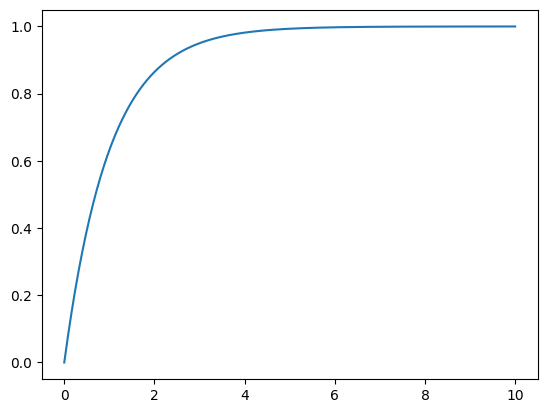

In [135]:
t = np.linspace(t0, t1, 500)
plt.plot(t, 1-jnp.exp(-t))

## Visualise parameters

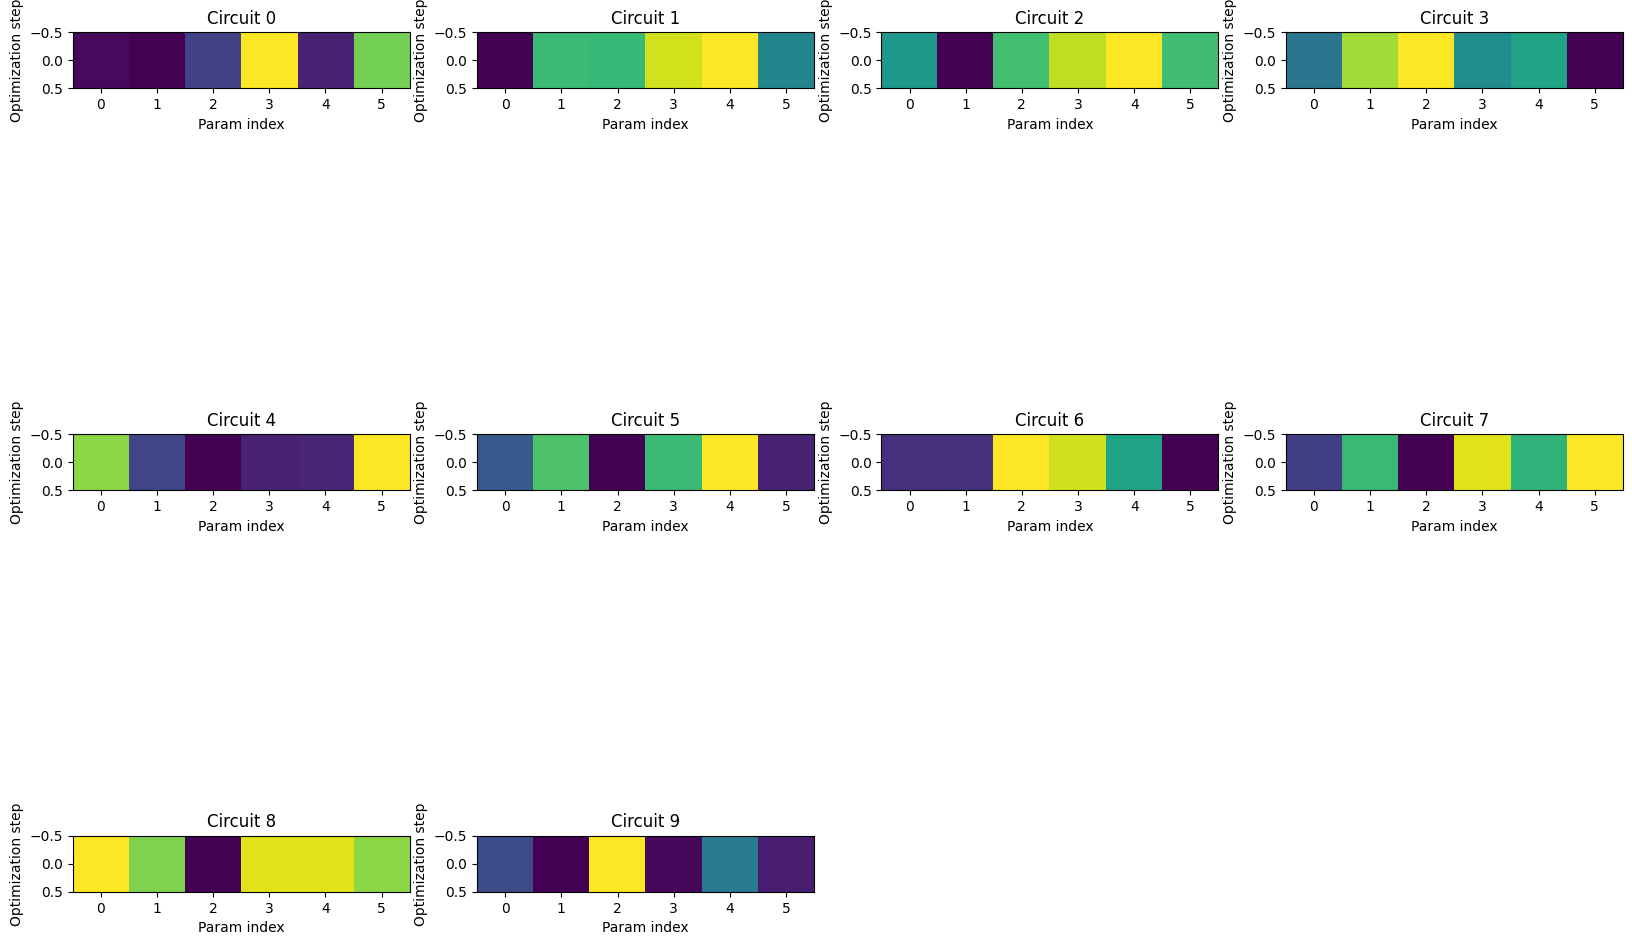

In [136]:
# plt.imshow(params_all)
nr = int(np.ceil(np.sqrt(n_circuits_display)))
nc = int(np.ceil(np.sqrt(n_circuits_display)))
fig = plt.figure(figsize=(5*nc, 5*nr))

for i in range(n_circuits_display):
    ax = plt.subplot(nr, nc, i+1)
    plt.imshow(params_all[:, i, :])
    plt.title(f'Circuit {i}')
    plt.xlabel('Param index')
    plt.ylabel('Optimization step')

## Visualise sensitivity and precision

Text(0.5, 0.98, 'Sensitivity and Precision objectives')

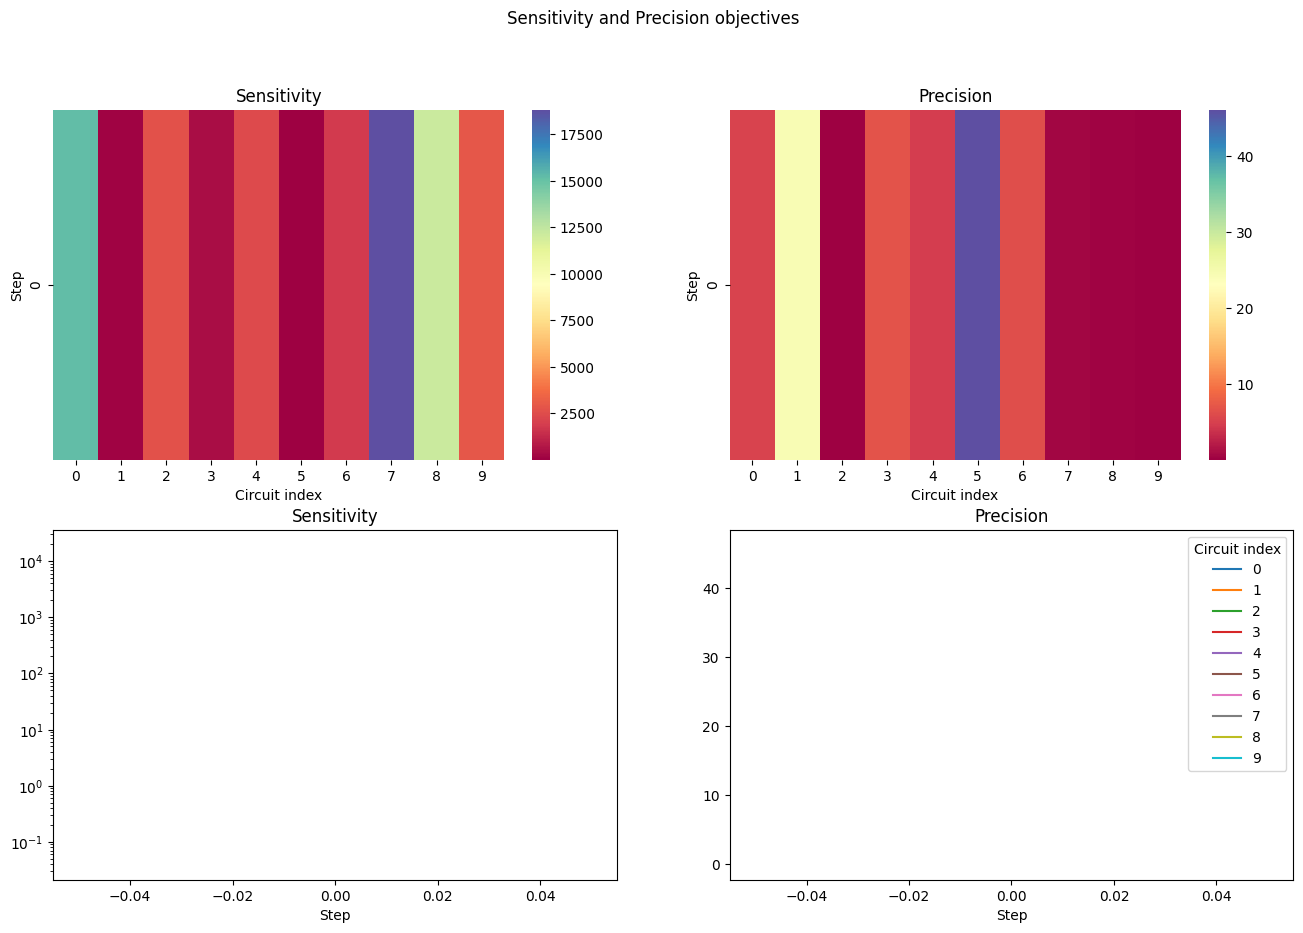

In [137]:
fig = plt.figure(figsize=(8*2, 5*2))
ax = plt.subplot(2, 2, 1)
sns.heatmap(s_obj_all, cmap='Spectral')
plt.title('Sensitivity')
plt.ylabel('Step')
plt.xlabel('Circuit index')
ax = plt.subplot(2, 2, 2)
sns.heatmap(p_obj_all, cmap='Spectral')
plt.title('Precision')
plt.ylabel('Step')
plt.xlabel('Circuit index')
ax = plt.subplot(2, 2, 3)
plt.plot(s_obj_all)
plt.yscale('log')
plt.xlabel('Step')
plt.title('Sensitivity')
ax = plt.subplot(2, 2, 4)
plt.plot(p_obj_all)
plt.xlabel('Step')
plt.title('Precision')
plt.legend(np.arange(n_circuits_display), title='Circuit index')
# plt.yscale('log')
plt.suptitle('Sensitivity and Precision objectives')